# Social Network

In [7]:
import random
import networkx as nx
import matplotlib.pyplot as plt

## Class definitions

In [205]:
class Post:
    def __init__(self, author, text, topic_distribution, sentiment_distribution):
        self.author = author
        self.text = text
        self.topic_distribution = topic_distribution
        self.sentiment_distribution = sentiment_distribution
        self.post_content_string = f"{self.author} posted: {self.text} {self.topic_distribution} being {self.sentiment_distribution}"
        self.viewed = []
        
        print(self.post_content_string)
        
    def __repr__(self):
        return self.post_content_string
    
    def add_viewed(self, agent):
        self.viewed.append(agent)

In [366]:
class Agent:
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None, engagement_rate=0.1):
        self.agent_id = agent_id
        self.followers = followers if followers else []
        self.following = []
        self.topic_preference = topic_preference if topic_preference else {}
        self.sentiment_preference = sentiment_preference if sentiment_preference else {}
        self.engagement_rate = engagement_rate
        self.post_history = []

    def tweet(self, content):
        post = Post(author = self.agent_id,
                    text = content["text"],
                    topic_distribution = content["topic_distribution"],
                    sentiment_distribution = content["sentiment_distribution"])
        self.post_history.append(post)
        return post

    def add_follower(self, follower_agent):
        self.followers.append(follower_agent)

    def follow(self, agent):
        self.following.append(agent)
        agent.add_follower(self)
        
    def remove_follower(self, follower_agent):
        self.followers.remove(follower_agent)
        
    def unfollow(self, agent):
        self.following.remove(agent)
        agent.remove_follower(self)
        
    def engage_with_post(self, post):#THIS SHOULD BE MORE OPTIMIZED.
        # Calculate engagement chance based on overlapping topics and probabilities
        positive_engagement_chance = 0.0
        for topic, post_prob in post.topic_distribution.items():
            if topic in self.topic_preference:
                # Weighted engagement chance for this topic
                topic_engagement = post_prob * self.topic_preference[topic] * self.engagement_rate
                positive_engagement_chance += topic_engagement
                
        # Calculate engagement chance based on overlapping sentiments and probabilities        
        for sentiment, post_prob in post.sentiment_distribution.items():
            if sentiment in self.sentiment_preference:
                # Weighted engagement chance for this sentiment
                sentiment_engagement = post_prob * self.sentiment_preference[sentiment] * self.engagement_rate
                positive_engagement_chance += sentiment_engagement
        
        negative_engagement_rate = 0.05 #from all the engagements, how many are negative, hate, ofensive... TO BE DEFINED!
        negative_engagement_chance = (1-positive_engagement_chance) * negative_engagement_rate
        if (random.random() < positive_engagement_chance):
            action = random.choices(["like", "retweet", "comment"], [0.7,0.1,0.2])[0] #Calibrate to real data!
            engagement_type = "positive"
            print(f"    {self.agent_id} {action}d post by {post.author} [et={engagement_type}, pec={round(positive_engagement_chance,2)}]")
            return action, engagement_type
        elif (random.random() < negative_engagement_chance):
            action = random.choice(["comment"])
            engagement_type = "negative"
            print(f"    {self.agent_id} {action}d post by {post.author} [et={engagement_type}, nec={round(negative_engagement_chance,2)}]")
            return action, engagement_type
        return None, None


class Influencer(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference, engagement_rate=0.3)
        self.type = 'Influencer'
        self.posting_frequency = 0.7
        self.follow_rate = 0.1
        self.unfollow_rate = 0.1

class Sharer(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference, engagement_rate=0.5)
        self.type = 'Sharer'
        self.posting_frequency = 0.2
        self.follow_rate = 0.5
        self.unfollow_rate = 0.1

class StandardUser(Agent):
    def __init__(self, agent_id, followers=None, topic_preference=None, sentiment_preference=None):
        super().__init__(agent_id, followers, topic_preference, sentiment_preference, engagement_rate=0.1)
        self.type = 'StandardUser'
        self.posting_frequency = 0.1
        self.follow_rate = 0.2
        self.unfollow_rate = 0.1

In [367]:
class SocialNetwork:
    def __init__(self):
        self.agents_set = {}
        self.graph = nx.DiGraph()

    def add_agent(self, agent):
        self.agents_set[agent.agent_id] = agent
        self.graph.add_node(agent.agent_id, type=agent.type) 

    def create_followers(self, agent_id, follower_ids):
        agent = self.agents_set[agent_id]
        for fid in follower_ids:
            if fid in self.agents_set:
                follower = self.agents_set[fid]
                follower.follow(agent)
                self.graph.add_edge(fid, agent_id)

    def propagate_post(self, writer, post):
        author = self.agents_set[post.author]
        for follower in writer.followers:
            if (follower not in post.viewed) and (follower != author):
                post.add_viewed(follower)
                action, engagement_type = follower.engage_with_post(post)
                if action:
                    if (engagement_type=="positive") and (random.random() < follower.follow_rate) and (follower not in author.followers):
                        follower.follow(author)
                        self.graph.add_edge(follower.agent_id, post.author)
                        print(f"    {follower.agent_id} started following {post.author} :)")
                    elif (engagement_type=="negative") and (random.random() < follower.unfollow_rate):
                        follower.unfollow(writer)
                        self.graph.remove_edge(follower.agent_id, writer.agent_id)
                        print(f"    {follower.agent_id} stopped following {writer.agent_id} :(")
                    self.propagate_post(follower, post)
                
    def step(self):
        for agent_id, agent in self.agents_set.items():
            if random.random() < agent.posting_frequency:
                content = {
                    "text": "Tweet about",
                    "topic_distribution": agent.topic_preference,
                    "sentiment_distribution": agent.sentiment_preference,
                    # To do: modify a bit preferneces form post to post. Not all post should follow strictly the authors preferences.
                }
                post = agent.tweet(content)
                self.propagate_post(agent, post)

    def visualize_network(self, step):
        fig, ax = plt.subplots(figsize=(18, 12))
        pos = nx.spring_layout(self.graph)
        colors = {'Influencer': 'red', 'Sharer': 'blue', 'StandardUser': 'green'}
        node_colors = [colors[self.graph.nodes[node]['type']] for node in self.graph.nodes]
        node_sizes = [100 + 2000 * len(self.agents_set[node].followers) for node in self.graph.nodes]

        nx.draw_networkx(self.graph, pos, node_color=node_colors, node_size=node_sizes, ax=ax, with_labels=True)
        ax.set_title(f'Social Network at Step {step}')

## Example 1: A simple one

#### Generate Network

Initial State:
Haoyuan has 4 followers
Lily has 3 followers
Josep has 1 followers
Mia has 2 followers
Andreu has 0 followers
Maria has 1 followers
Tom has 1 followers


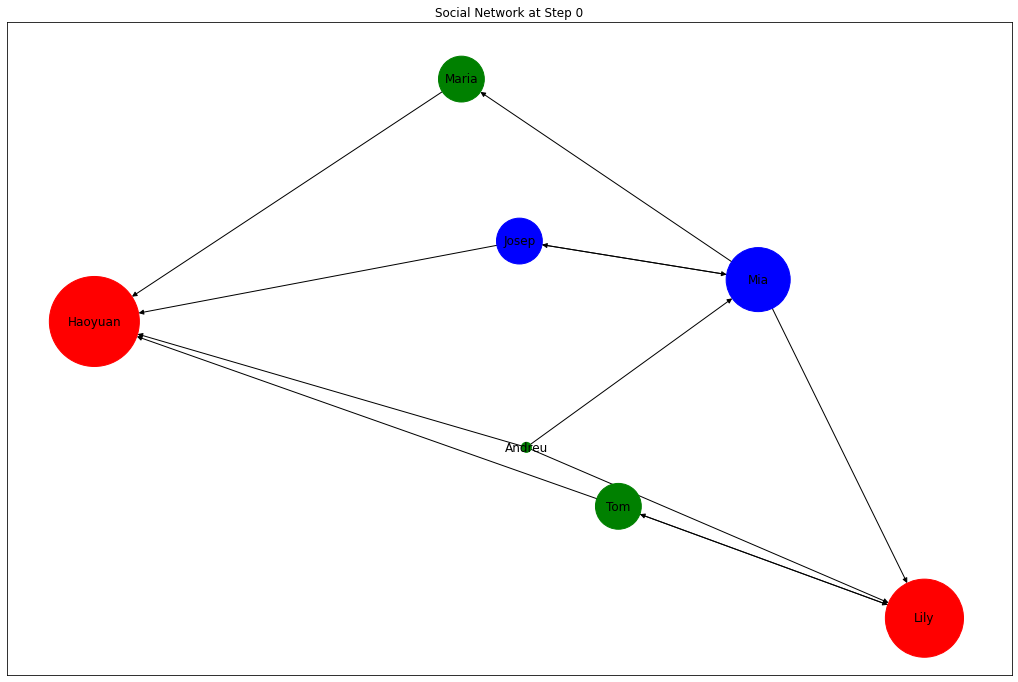

In [372]:
network = SocialNetwork()

# Create and add agents with varying interests and roles
# Influencers
influencer1 = Influencer(
    "Haoyuan", 
    topic_preference={"tech": 0.7, "politics": 0.3},
    sentiment_preference={"negative": 0.2, "neutral": 0.3, "positive": 0.5}
)

influencer2 = Influencer(
    "Lily", 
    topic_preference={"lifestyle": 0.8, "fitness": 0.2},
    sentiment_preference={"negative": 0.1, "neutral": 0.4, "positive": 0.5}
)

# Sharers
sharer1 = Sharer(
    "Josep", 
    topic_preference={"lifestyle": 1.0},
    sentiment_preference={"negative": 0.1, "neutral": 0.5, "positive": 0.3}
)

sharer2 = Sharer(
    "Mia", 
    topic_preference={"lifestyle": 0.7, "fitness": 0.3},
    sentiment_preference={"negative": 0.1, "neutral": 0.5, "positive": 0.5}
)

# Standard Users
standard_user1 = StandardUser(
    "Andreu", 
    topic_preference={"lifestyle": 1.0},
    sentiment_preference={"negative": 0.3, "neutral": 0.3, "positive": 0.4}
)

standard_user2 = StandardUser(
    "Maria", 
    topic_preference={"science": 0.6, "politics": 0.4},
    sentiment_preference={"negative": 0.25, "neutral": 0.5, "positive": 0.25}
)

standard_user3 = StandardUser(
    "Tom", 
    topic_preference={"tech": 0.5, "travel": 0.5},
    sentiment_preference={"negative": 0.2, "neutral": 0.3, "positive": 0.5}
)


# Register agents in the network
network.add_agent(influencer1)
network.add_agent(influencer2)
network.add_agent(sharer1)
network.add_agent(sharer2)
network.add_agent(standard_user1)
network.add_agent(standard_user2)
network.add_agent(standard_user3)

# Create follower relationships
network.create_followers("Haoyuan", ["Josep", "Andreu", "Maria", "Tom"])
network.create_followers("Lily", ["Mia", "Andreu", "Tom"])

network.create_followers("Josep", ["Mia"])
network.create_followers("Mia", ["Josep", "Andreu"])

network.create_followers("Andreu", [])
network.create_followers("Maria", ["Mia"])
network.create_followers("Tom", ["Lily"])

print("Initial State:")
network.visualize_network(step=0)
for agent_id, agent in network.agents_set.items():
    print(f"{agent_id} has {len(agent.followers)} followers")

#### Temporal evolution

In [373]:
%%capture capt
n_steps = 50
for i in range(1, n_steps):
    print(f"\nStep {i}")
    network.step()

**Output only steps where the structure of the network changes.**
Note that Josep started following Lily since Mia retweeted Lily's post.

In [374]:
lines = capt.stdout.split('\nStep ')
for line in lines:
    if "following" in line:
        print(line)

2
Haoyuan posted: Tweet about {'tech': 0.7, 'politics': 0.3} being {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5}
Lily posted: Tweet about {'lifestyle': 0.8, 'fitness': 0.2} being {'negative': 0.1, 'neutral': 0.4, 'positive': 0.5}
    Mia liked post by Lily [et=positive, pec=0.54]
    Josep liked post by Lily [et=positive, pec=0.58]
    Josep started following Lily :)

33
Haoyuan posted: Tweet about {'tech': 0.7, 'politics': 0.3} being {'negative': 0.2, 'neutral': 0.3, 'positive': 0.5}
    Tom commentd post by Haoyuan [et=positive, pec=0.07]
Lily posted: Tweet about {'lifestyle': 0.8, 'fitness': 0.2} being {'negative': 0.1, 'neutral': 0.4, 'positive': 0.5}
    Mia commentd post by Lily [et=positive, pec=0.54]
    Josep liked post by Lily [et=positive, pec=0.58]
    Andreu commentd post by Lily [et=negative, nec=0.04]
    Tom commentd post by Lily [et=negative, nec=0.05]
    Tom stopped following Lily :(
Andreu posted: Tweet about {'lifestyle': 1.0} being {'negative': 0.3, 'neutral'

#### Report final state

Final State:
Haoyuan has 3 followers
Lily has 3 followers
Josep has 1 followers
Mia has 2 followers
Andreu has 0 followers
Maria has 1 followers
Tom has 1 followers


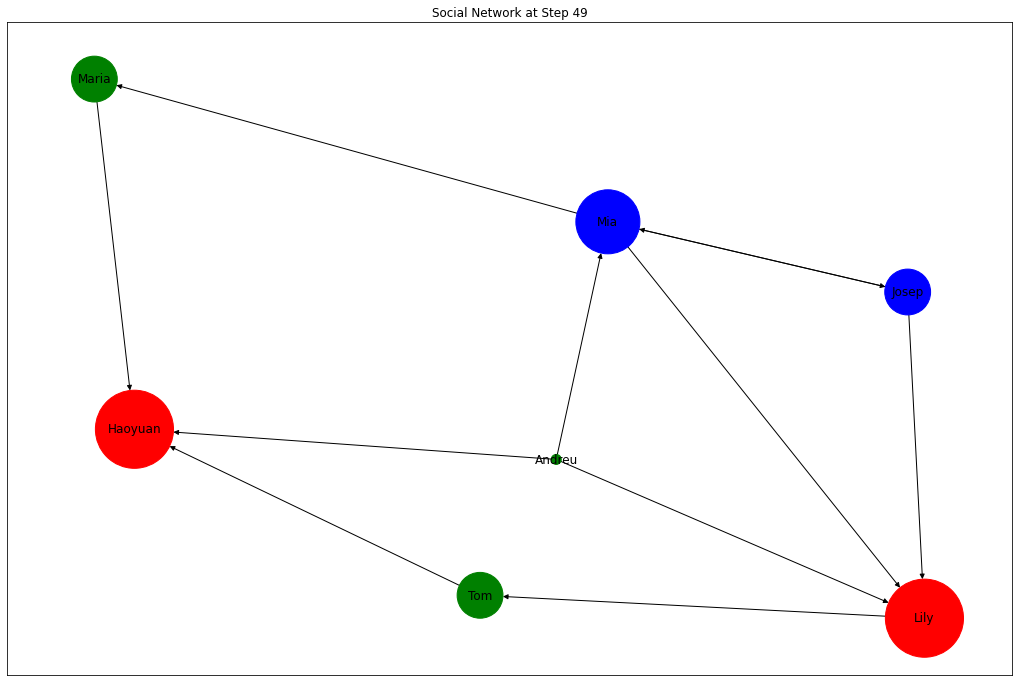

In [375]:
print("Final State:")
network.visualize_network(step=i)
for agent_id, agent in network.agents_set.items():
    print(f"{agent_id} has {len(agent.followers)} followers")

### Notes for the future

- Obviously calibrate model with real data.

- (DONE) Add negative actions such as unfollow.
- Define better when negative actions occurr. Is it good doing the (1-pec)?
- (DONE) Add action comment.
- (DONE) Work with probabilities, a post should have multiple topics.
- (DONE) Add sentiment preferences.
- (DONE) Make posts an object? and keep track that one can not like a post twice.
- Add other atributes.
- In general check again for possible infinite loops due to recursiveness.
- The way agents interact will be way more complex.
- Random choices could be substituted by reinforcement learning. Parameters to be modified will be the probabilities of the atributes and the rewards are likes and follows. Might converge or not, also no idea what I would expect to want.
- Atributes should have a temporal component?. Everything should have a temporal component? How would you do this?
- We will need to include a simple algorithm to recommend outside your network based on trending posts. Kind of an ´explore´. Also to sort your content feed.
- Include slacks and biases, not everything should be perfect.
- Periodical addition of new users.
- Consider Transfer between agent classes: Influencer canceled of standard becoming popular.